# Training ML models

In [1]:
import librosa
import librosa.display
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import pickle

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense, Activation, Input
from keras.callbacks import Callback
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
import keras.optimizers
from keras.utils import np_utils
from tensorflow.keras.layers import Dropout

from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import shap

import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\gabis\Anaconda3\envs\sigproc\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Matriz de confusão',cmap=plt.cm.RdPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real')
    plt.xlabel('Predito')

## Data processing

In [3]:
df = pd.read_csv('..\data\extracted_data\data.csv')

In [4]:
df.shape

(3715, 27)

In [5]:
# drop id column

df.drop(columns= ['filename'], inplace = True)

In [6]:
df.label.value_counts()

gel    760
pia    721
sax    626
vio    580
tru    577
flu    451
Name: label, dtype: int64

In [7]:
# shuffle labels

df_shuffle = shuffle(df, random_state=42)

In [8]:
df_shuffle.reset_index(drop=True, inplace=True)

In [9]:
df_shuffle.head()

,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.030512,1056.959090,1471.475422,2032.767631,0.026412,-364.248138,229.218964,-27.175459,27.648891,17.194578,...,-2.664470,-0.904348,-2.786990,3.495105,2.150302,1.165722,4.232224,4.165151,2.465964,vio
1,0.079626,2580.591615,2365.503295,4295.250475,0.091412,-202.907120,159.787979,-83.150368,41.476490,6.053060,...,-3.815774,5.548301,0.396753,-0.901491,-5.130464,9.529392,-1.118356,-2.970000,-4.175096,gel
2,0.288886,1245.476485,1617.597245,2132.535367,0.027968,-237.171219,179.418503,-30.569599,4.160762,18.825945,...,-2.184085,8.356164,5.979440,-5.624641,-13.162045,-12.961650,-12.009631,-6.953019,-2.885999,flu
3,0.063797,5134.238150,4946.826927,10792.125475,0.127323,-155.442322,90.009262,-8.579554,36.486843,-2.567492,...,1.932332,-7.009566,2.302116,-9.365165,6.210819,-8.491085,2.249443,-5.517708,6.216122,sax
4,0.072615,1022.722143,1179.473424,1669.446791,0.031497,-301.733856,240.379807,-29.722519,6.572226,2.597335,...,0.447803,2.539366,-0.006181,-5.901525,-10.414945,-8.224915,-8.953121,-7.624854,-3.772103,pia


In [10]:
# separate features and target

X = df_shuffle.drop(columns = ['label'])
y = df_shuffle.label.copy()

In [11]:
# split train test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# standardize features by removing the mean and scaling to unit variance

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(np.array(X_train, dtype = float)), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(np.array(X_test, dtype = float)), index=X_test.index, columns=X_test.columns)

In [ ]:
# scaler dump
pickle.dump(scaler, open('..\models\scaler', 'wb'))

In [13]:
# label distribution in train and test set

y_train.value_counts()

pia    527
gel    519
sax    445
vio    420
tru    388
flu    301
Name: label, dtype: int64

In [14]:
y_test.value_counts()

gel    241
pia    194
tru    189
sax    181
vio    160
flu    150
Name: label, dtype: int64

In [15]:
X_train.to_csv('../data/dump/X_train.csv')
X_test.to_csv('../data/dump/X_test.csv')
y_train.to_csv('../data/dump/y_train.csv')
y_test.to_csv('../data/dump/y_test.csv')

In [ ]:
df = pd.read_csv('..\data\extracted_data\data.csv')

In [5]:
X_train = pd.read_csv('../data/dump/X_train.csv', index_col=0)
X_test = pd.read_csv('../data/dump/X_test.csv', index_col=0)
y_train = pd.read_csv('../data/dump/y_train.csv', index_col=0)
y_test = pd.read_csv('../data/dump/y_test.csv', index_col=0)

## Data modeling

### svc

grid

In [16]:
# param_grid = {'C':[3, 7, 10, 15, 30, 50, 100],'gamma':[0.1, 0.05, 0.5, 0.03], 'kernel':['rbf']}
param_grid = {'C':[7, 10, 50],'gamma':[0.1, 0.05]}

In [17]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose=2)

In [18]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................................C=7, gamma=0.1; total time=   0.3s
[CV] END .....................................C=7, gamma=0.1; total time=   0.3s
[CV] END .....................................C=7, gamma=0.1; total time=   0.3s
[CV] END .....................................C=7, gamma=0.1; total time=   0.3s
[CV] END .....................................C=7, gamma=0.1; total time=   0.3s
[CV] END ....................................C=7, gamma=0.05; total time=   0.2s
[CV] END ....................................C=7, gamma=0.05; total time=   0.2s
[CV] END ....................................C=7, gamma=0.05; total time=   0.2s
[CV] END ....................................C=7, gamma=0.05; total time=   0.2s
[CV] END ....................................C=7, gamma=0.05; total time=   0.2s
[CV] END ....................................C=10, gamma=0.1; total time=   0.3s
[CV] END ....................................C=10

GridSearchCV(estimator=SVC(),
             param_grid={'C': [7, 10, 50], 'gamma': [0.1, 0.05]}, verbose=2)

In [19]:
grid.best_params_
#{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

{'C': 10, 'gamma': 0.1}

In [20]:
svc = SVC(C = 10, gamma= 0.1, kernel = 'rbf', random_state = 42, probability=True)

In [21]:
scores = cross_val_score(svc, X_train, y_train, cv=5)

In [22]:
# train metrics 

scores

array([0.69615385, 0.69230769, 0.67115385, 0.69807692, 0.70769231])

In [23]:
scores.mean()

0.6930769230769231

In [24]:
svc.fit(X_train, y_train)

SVC(C=10, gamma=0.1, probability=True, random_state=42)

In [25]:
svc = pickle.load(open('..\models\svc_model', 'rb'))

In [26]:
preds = svc.predict(X_test)

In [27]:
# test metrics

print(classification_report(y_test,preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

         flu       0.62      0.65      0.64       150
         gel       0.78      0.84      0.81       241
         pia       0.74      0.73      0.74       194
         sax       0.67      0.65      0.66       181
         tru       0.78      0.69      0.73       189
         vio       0.69      0.70      0.69       160

    accuracy                           0.72      1115
   macro avg       0.71      0.71      0.71      1115
weighted avg       0.72      0.72      0.72      1115

[[ 98  12  10  13   9   8]
 [ 10 203   5   3   8  12]
 [ 13  11 142  17   4   7]
 [ 12  14  16 117   9  13]
 [ 17   6   7  17 131  11]
 [  8  14  11   8   7 112]]


In [28]:
from pretty_confusion_matrix import pp_matrix

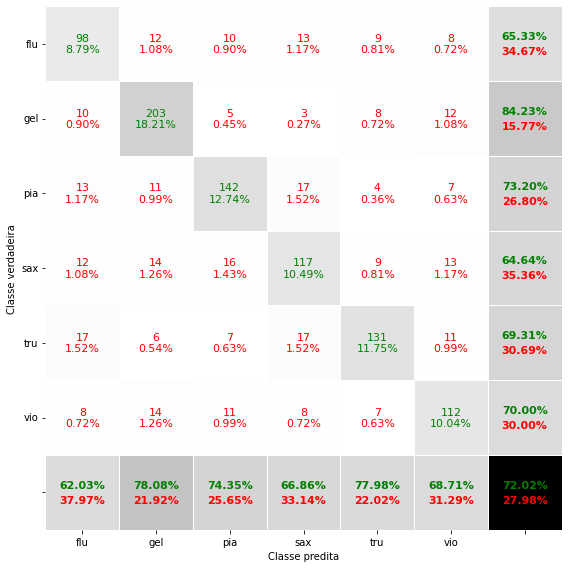

In [33]:
# teste matriz de confusão
# from pretty_confusion_matrix import pp_matrix
df_cm = pd.DataFrame(confusion_matrix(y_test, preds), index=svc.classes_, columns=svc.classes_)
pp_matrix(df_cm,  path='..\images\code_generated\heat\heat_svc_2.png', pred_val_axis = 'x', cmap='gist_yarg')

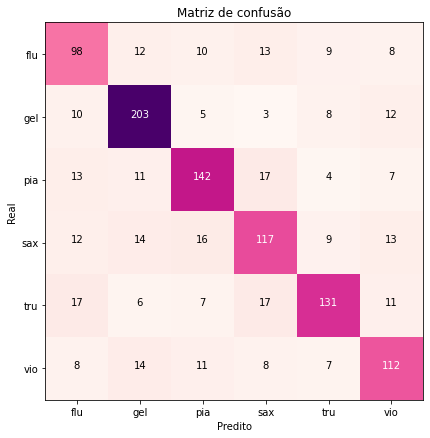

In [28]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix(y_test, preds), classes=svc.classes_)
# plt.savefig('..\images\code_generated\heat\heat_svc.png', bbox_inches='tight')

In [32]:
# model dump
pickle.dump(svc, open('..\models\svc_model', 'wb'))

### ANN

In [29]:
le = LabelEncoder()
le_y = le.fit_transform(y)

# convert integers to dummy variables - one hot encoded
dummy_y = np_utils.to_categorical(le_y)

In [30]:
pd.concat([y, pd.DataFrame(le_y)], axis=1).groupby(['label']).first()

,0
label,
flu,0
gel,1
pia,2
sax,3
tru,4
vio,5


In [31]:
pd.concat([y, pd.DataFrame(dummy_y)], axis=1).groupby(['label']).first()

,0,1,2,3,4,5
label,,,,,,
flu,1.0,0.0,0.0,0.0,0.0,0.0
gel,0.0,1.0,0.0,0.0,0.0,0.0
pia,0.0,0.0,1.0,0.0,0.0,0.0
sax,0.0,0.0,0.0,1.0,0.0,0.0
tru,0.0,0.0,0.0,0.0,1.0,0.0
vio,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
dummy_y

array([[0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [33]:
X_train_rna, X_test_rna, y_train_rna, y_test_rna = train_test_split(X, dummy_y, test_size=0.3, random_state= 42)

In [34]:
X_train_rna.shape

(2600, 25)

In [35]:
model = Sequential()
model.add(Input(25))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(128, activation='relu', input_dim=18))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

In [36]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

In [39]:
results = model.fit(X_train, y_train_rna, epochs=200, batch_size=32,validation_data=(X_test, y_test_rna), callbacks=[callback])

Epoch 1/200
82/82 [==============================] - 1s 3ms/step - loss: 1.9635 - accuracy: 0.1477 - val_loss: 1.9604 - val_accuracy: 0.1417
Epoch 2/200
82/82 [==============================] - 0s 2ms/step - loss: 1.9119 - accuracy: 0.1531 - val_loss: 1.9103 - val_accuracy: 0.1507
Epoch 3/200
82/82 [==============================] - 0s 2ms/step - loss: 1.8685 - accuracy: 0.1631 - val_loss: 1.8672 - val_accuracy: 0.1623
Epoch 4/200
82/82 [==============================] - 0s 2ms/step - loss: 1.8308 - accuracy: 0.1754 - val_loss: 1.8297 - val_accuracy: 0.1830
Epoch 5/200
82/82 [==============================] - 0s 2ms/step - loss: 1.7981 - accuracy: 0.2081 - val_loss: 1.7980 - val_accuracy: 0.2135
Epoch 6/200
82/82 [==============================] - 0s 2ms/step - loss: 1.7702 - accuracy: 0.2446 - val_loss: 1.7708 - val_accuracy: 0.2511
Epoch 7/200
82/82 [==============================] - 0s 2ms/step - loss: 1.7461 - accuracy: 0.2673 - val_loss: 1.7471 - val_accuracy: 0.2771
Epoch 8/200
8

In [40]:
train_loss, train_acc = model.evaluate(X_train,  y_train_rna, verbose=2)

82/82 - 0s - loss: 1.3061 - accuracy: 0.5231 - 88ms/epoch - 1ms/step


In [41]:
test_loss, test_acc = model.evaluate(X_test,  y_test_rna, verbose=2)

35/35 - 0s - loss: 1.3473 - accuracy: 0.4888 - 54ms/epoch - 2ms/step


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3328      
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 4,102
Trainable params: 4,102
Non-trainable params: 0
_________________________________________________________________


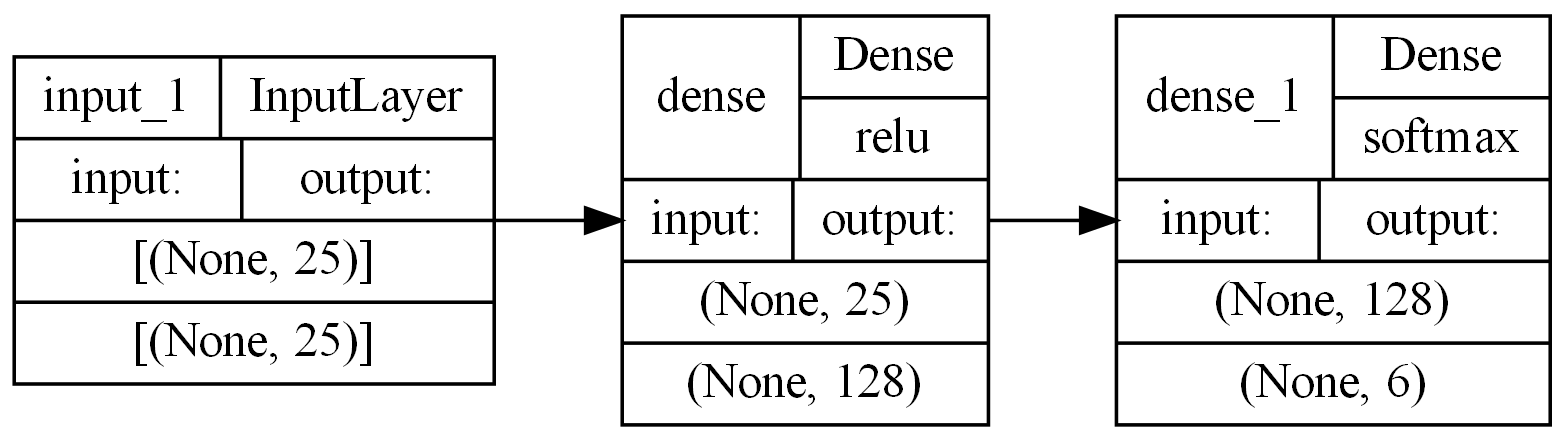

In [43]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, rankdir='LR', dpi=256, to_file='../images/code_generated/ann.png')

In [44]:
results.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [6]:
model = tf.keras.models.load_model('../models/ann_model.h5')

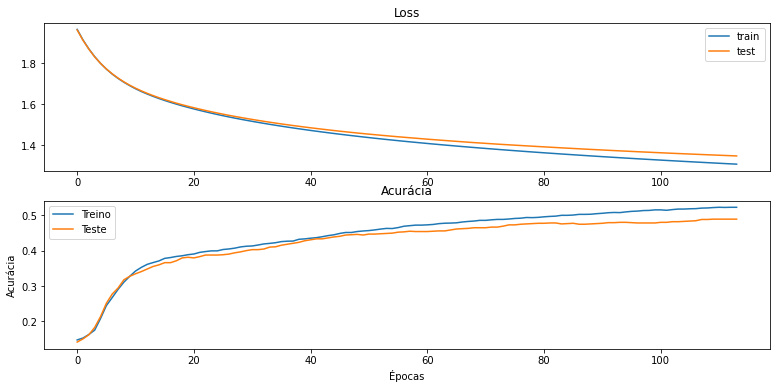

In [45]:
plt.figure(figsize=(13,6))
plt.subplot(211)
plt.title('Loss')
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='test')
plt.legend()
plt.subplot(212)
plt.title('Acurácia')
plt.plot(results.history['accuracy'], label='Treino')
plt.plot(results.history['val_accuracy'], label='Teste')
plt.legend()
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
# plt.savefig('../images/code_generated/ann_epochs.png', bbox_inches='tight')
plt.show()

In [27]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

In [51]:
le.inverse_transform(np.argmax(y_test_rna, axis=1))

array(['tru', 'gel', 'pia', ..., 'tru', 'gel', 'vio'], dtype=object)

In [52]:
le.inverse_transform(classes_x)

array(['gel', 'gel', 'pia', ..., 'pia', 'gel', 'vio'], dtype=object)

In [54]:
print(classification_report(le.inverse_transform(np.argmax(y_test_rna, axis=1)), le.inverse_transform(classes_x)))
print(confusion_matrix(le.inverse_transform(np.argmax(y_test_rna, axis=1)), le.inverse_transform(classes_x)))

              precision    recall  f1-score   support

         flu       0.47      0.21      0.29       150
         gel       0.48      0.80      0.60       241
         pia       0.49      0.71      0.58       194
         sax       0.37      0.20      0.26       181
         tru       0.52      0.34      0.41       189
         vio       0.48      0.42      0.45       160

    accuracy                           0.48      1115
   macro avg       0.47      0.45      0.43      1115
weighted avg       0.47      0.48      0.45      1115

[[ 31  38  36  15  12  18]
 [  4 194  22   7   6   8]
 [  9  27 138   8   6   6]
 [ 10  55  36  37  24  19]
 [  3  56  26  18  64  22]
 [  9  35  24  14  11  67]]


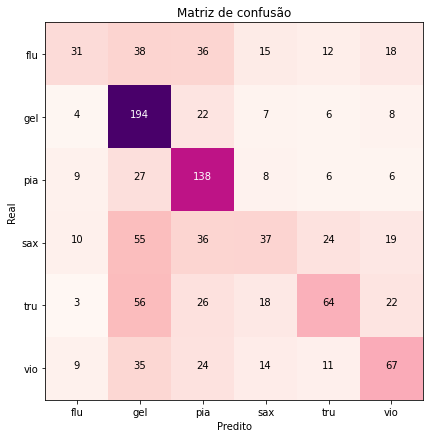

In [56]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix(le.inverse_transform(np.argmax(y_test_rna, axis=1)), le.inverse_transform(classes_x)), classes=['flu', 'gel', 'pia', 'sax', 'tru', 'vio'])
# plt.savefig('..\images\code_generated\heat\heat_ann.png', bbox_inches='tight')

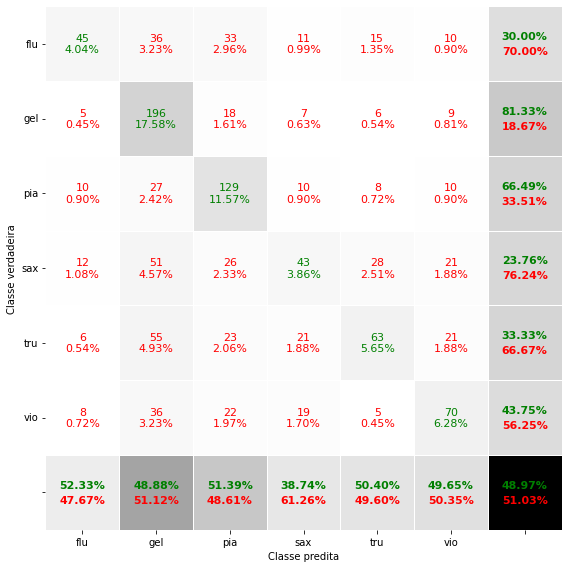

In [30]:
# teste matriz de confusão
df_cm = pd.DataFrame(confusion_matrix(le.inverse_transform(np.argmax(y_test_rna, axis=1)), le.inverse_transform(classes_x)), index=['flu', 'gel', 'pia', 'sax', 'tru', 'vio'], columns=['flu', 'gel', 'pia', 'sax', 'tru', 'vio'])
pp_matrix(df_cm,  path='..\images\code_generated\heat\heat_ann_2.png', pred_val_axis = 'x', cmap='gist_yarg')

In [26]:
model = tf.keras.models.load_model('../models/ann_model.h5')

In [61]:
# model dump
model.save('../models/ann_model.h5')

### Random Forest

In [58]:
# param_grid = {'n_estimators':[100, 300, 500, 750, 1000],
#               'max_depth':[2, 5, 7, 10],
#               'max_features':[0.2, 0.5, 0.7, 1.0],
#               'min_samples_leaf':[2, 5, 7],
#               'min_samples_split': [8, 10, 12]
#               }

param_grid = {'n_estimators':[100, 500, 1000],
              'max_depth':[5, 10],
              'max_features':[0.5, 1.0],
              'min_samples_leaf':[2, 7],
              'min_samples_split': [8, 12]
              }

In [59]:
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit = True, verbose=2, n_jobs = -1)

In [60]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': [0.5, 1.0],
                         'min_samples_leaf': [2, 7],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 500, 1000]},
             verbose=2)

In [62]:
clf = RandomForestClassifier(max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=8, n_estimators= 100, random_state=42)

In [63]:
scores = cross_val_score(clf, X_train, y_train, cv=5)

In [64]:
scores.mean()

0.5896153846153845

In [65]:
scores

array([0.61153846, 0.575     , 0.59230769, 0.6       , 0.56923077])

In [65]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features=1.0, min_samples_leaf=2,
                       min_samples_split=8, random_state=42)

In [34]:
clf = pickle.load(open('../models/rf_model', 'rb'))

In [35]:
preds = clf.predict(X_test)

In [67]:
print(classification_report(y_test,preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

         flu       0.60      0.35      0.45       150
         gel       0.58      0.76      0.66       241
         pia       0.52      0.75      0.61       194
         sax       0.52      0.43      0.47       181
         tru       0.66      0.53      0.59       189
         vio       0.62      0.51      0.56       160

    accuracy                           0.57      1115
   macro avg       0.58      0.56      0.56      1115
weighted avg       0.58      0.57      0.57      1115

[[ 53  25  32  13  16  11]
 [  8 182  22  18   5   6]
 [  7  19 145   9   8   6]
 [  7  36  30  78  13  17]
 [  4  23  33  17 101  11]
 [  9  27  16  16  10  82]]


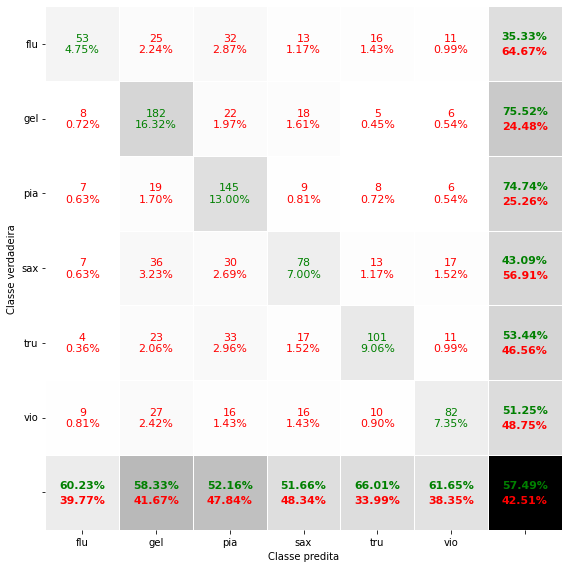

In [36]:
df_cm = pd.DataFrame(confusion_matrix(y_test, preds), index=clf.classes_, columns=clf.classes_)
pp_matrix(df_cm,  path='..\images\code_generated\heat\heat_rf_2.png', pred_val_axis = 'x', cmap='gist_yarg')

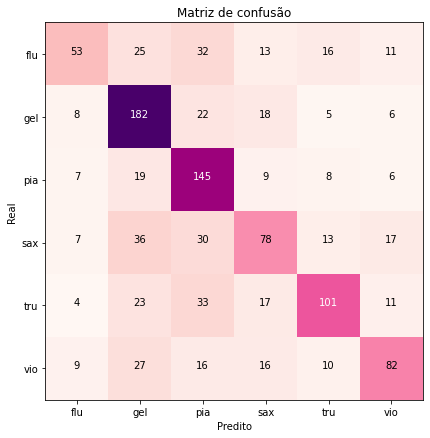

In [69]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix(y_test, preds), classes=clf.classes_)
# plt.savefig('..\images\code_generated\heat\heat_rf.png', bbox_inches='tight')

In [71]:
# model dump
pickle.dump(clf, open('../models/rf_model', 'wb'))